In [1]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import gluonnlp as nlp

#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#GPU 사용
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

import warnings
warnings.filterwarnings('ignore')

C:\Users\Tiger\anaconda3\envs\kakao\lib\site-packages\mxnet\optimizer\optimizer.py:167: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  Optimizer.opt_registry[name].__name__))


using cached model
using cached model


In [2]:
class BERTDataset(Dataset):
    def __init__(self, dataset, bert_tokenizer, args):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=args.max_len, pad=args.pad, pair=args.pair)

        self.sentences = [transform([i]) for i in dataset]

    def __getitem__(self, i):
        return self.sentences[i]

    def __len__(self):
        return (len(self.sentences))

In [3]:
class BERTClassifier(nn.Module):
    def __init__(self, 
                 bert, 
                 hidden_size=768, 
                 num_classes=7,
                 dr_rate=0.5,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size, num_classes)
        if self.dr_rate:
            self.dropout = nn.Dropout(p=self.dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [4]:
def test(model, data_test, args):
    test_dataloader = DataLoader(data_test, 
                                 batch_size=args.batch_size) #, num_workers=args.num_workers) 

    model.eval()
    
    current_preds = []
    
    with torch.no_grad():
        for token_ids, valid_length, segment_ids in test_dataloader:
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            valid_length= valid_length
            out = model(token_ids, valid_length, segment_ids)
            
            _, predicted = torch.max(out.data, 1)

            current_preds.extend(predicted)
            
    return current_preds

In [5]:
model = BERTClassifier(bertmodel).to(device)
model.load_state_dict(torch.load('./weight/bert_1.pt'))

<All keys matched successfully>

In [6]:
import argparse
from copy import deepcopy

#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

# ====== Random seed Initialization ====== #
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

# Setting parameters
args.max_len = 64
args.pad = True
args.pair = False

args.num_workers = 4
args.batch_size = 64

using cached model


In [7]:
def pre(file_name):
    name_list = []
    time_list = []
    chat_list = []

    with open(f'./data/{file_name}.txt', 'r', encoding='UTF-8') as f:
        for line in f.readlines():
            line = line[:-1]
            patt = r'] '
            spl = re.split(patt, line, maxsplit=2)
            if len(spl) == 3:
                name_list.append(spl[0][1:])
                time_list.append(spl[1][1:])
                chat_list.append(spl[2])
            elif len(spl) == 1 and len(spl[0]) != 0:
                if len(name_list) != 0:
                    name_list.append(name_list[-1])
                    time_list.append(time_list[-1])
                    chat_list.append(spl[0])
    f.close()

    data = pd.DataFrame()
    data['Name'] = name_list
    data['Time'] = time_list
    data['Chat'] = chat_list

    # 이름 제거
    names = data['Name'].unique()
    for i, n in enumerate(names):
        data.loc[(data['Name'] == n), 'Name'] = i
    
    return data

In [8]:
def analy(data, name):
    # 감정 분석
    target = data['Chat'].tolist()
    data_test = BERTDataset(target, tok, args)
    pred_list = test(model, data_test, args)
    
    emo = []
    p_l = []
    for e in pred_list:
        a = e.to('cpu').numpy()
        emo.append(a)
    
        if a == 0:
            a = '공포'
        elif a == 1:
            a = '놀람'
        elif a == 2:
            a = '분노'
        elif a == 3:
            a = '슬픔'
        elif a == 4:
            a = '중립'
        elif a == 5:
            a = '행복'
        elif a == 6:
            a = '혐오'
        p_l.append(a)
    
    data['Emotion'] = p_l

    # 화자 분리
    remove_list = []   
    for s in name:
        select_list = []
        for i, n in enumerate(data['Name']):
            if n == s:
                select_list.append(i)
                
        remove_list.append(select_list)

    each_emotion = []
    for k in range(len(name)):
        emotion_count = [0,0,0, 0,0,0, 0]
        for j, r in enumerate(emo):
            if j in remove_list[k]:
                emotion_count[r] += 1
                
        each_emotion.append(emotion_count)
        
    # print(f'공포 : {emotion_count[0]}')
    # print(f'놀람 : {emotion_count[1]}')
    # print(f'분노 : {emotion_count[2]}')
    # print(f'슬픔 : {emotion_count[3]}')
    # print(f'중립 : {emotion_count[4]}')
    # print(f'행복 : {emotion_count[5]}')
    # print(f'혐오 : {emotion_count[6]}')
    
    return data, each_emotion

In [9]:
file_name = 'emotion_tolk'
all_chat = pre(file_name)

In [10]:
names = all_chat['Name'][:20].unique()
data, res = analy(all_chat, names)

,Name,Time,Chat,Emotion
0,0,오후 4:29,네,중립
1,0,오후 4:29,쨘,슬픔
2,0,오후 4:29,뿅,슬픔
3,1,오후 4:30,사진 찍어서 보내주께!ㅋㅋ,행복
4,1,오후 4:30,시러할수도 있으니까,공포
...,...,...,...,...
4490,1,오후 9:30,"오늘도 고생했어~ 좋은밤 보내!!^,^",행복
4491,0,오후 11:20,배불러서 또 못 자네,중립
4492,0,오후 11:20,--------------- 2021년 12월 1일 수요일 ---------------,놀람
4493,1,오전 12:24,굿나잇,행복


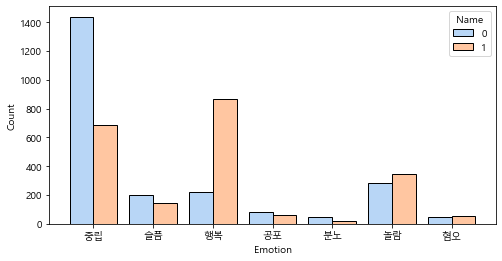

In [11]:
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

plt.figure(figsize=(8,4))
ax = sns.histplot(data=data, x='Emotion', hue='Name', multiple="dodge", shrink=.8, palette='pastel')
data

In [12]:
file_name = 'ekaud'
all_chat = pre(file_name)

In [13]:
names = all_chat['Name'].unique()
data, res = analy(all_chat, names)

,Name,Time,Chat,Emotion
0,0,오전 9:42,나왔다 임마,중립
1,1,오전 9:43,(컴온),중립
2,1,오전 9:43,다 들어오면 천천히 일자를 정해보세,중립
3,0,오전 9:44,11월19일,중립
4,0,오전 9:44,18일부터 추가접종백신휴가다,중립
...,...,...,...,...
357,0,오후 6:34,왠만하면 애들에게 붙게,중립
358,2,오후 7:42,난 12일 조조로 가야지 ㅋㅋ,중립
359,1,오후 7:57,금토일 주말은 피할래,중립
360,2,오후 8:01,난 어쩔 수 없으니 머 ㅋㅋ,행복


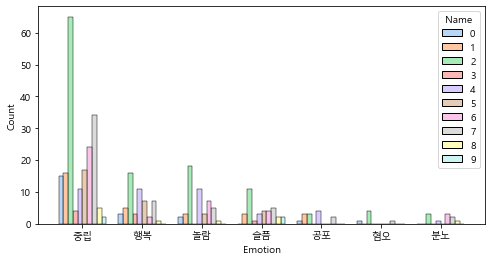

In [14]:
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

plt.figure(figsize=(8,4))
ax = sns.histplot(data=data, x='Emotion', hue='Name', multiple="dodge", shrink=.8, palette='pastel')
data

In [15]:
end

NameError: name 'end' is not defined

In [ ]:
data_list = []
question = input('문장을 입력하세요 :')
data_list.append(question)

In [ ]:
data_test = BERTDataset(data_list, tok, args)
pred_list = test(model, data_test, args)
pred_list